# Main
## Part 1 - Face Detection
In this project, we aim to construct a face detection model. We used a method haar to extract features. After that, by applying extracted features to cascade method, we were able to dectect people's faces and also count the number of faces through pictures as well as webcam. Pre-trained cascade was used from OpenCV. 

We suggest clone or download the whole repository to reproduce the result. You can reproduce them all from this notebook. Besides, you are encouraged to add your own test images simply by putting all the images you want to test into the data/test_data/cascade or data/test_data/tensorflow directory. 

You can hit the button below to show the full codes and hsit again to collapse all cells.

### Part 1.1 - Face Detection without Rotation on Image
We started off the project with face detection on an image. 

In [177]:
import numpy as np
import os
import sys
import ipywidgets as widgets
from pathlib import Path
from matplotlib import pyplot as plt
from IPython.display import HTML
from IPython.display import display


In [167]:
# Collapse cells
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [186]:
# %load ../lib/count_face.py
def counting_face():
    import numpy as np
    import cv2
    from matplotlib import pyplot as plt

    # loading OpenCV cascade for haar method with frontal face
    face_cascade = cv2.CascadeClassifier('../lib/haarcascade_frontalface_default.xml')

    # loading test image
    img = cv2.imread('../data/test_image/104.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.2, 5)

    # implementing model
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),8)

    # showing image
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,8))
    plt.imshow(RGB_img)
    plt.show()



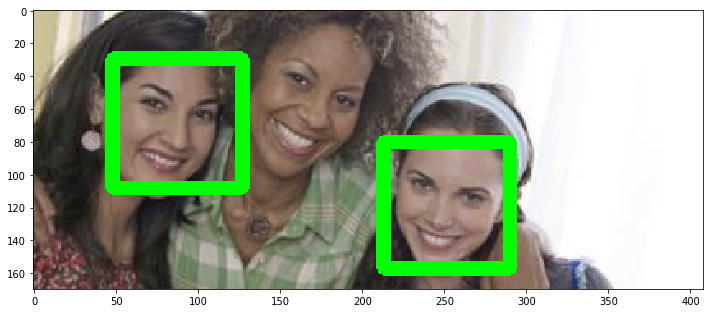

In [187]:
counting_face()

### Part 1.2 - Face Detection with Rotation
After implementation of Part 1, we realized the OpenCV front face cascade could not detect rotated face. Hence, we made some adjustments and declared additional functions to allow our model to analyze images from different rotation angle.

In [188]:
# %load ../lib/counting_faces_image.py
#!/usr/bin/env python3
"""
Created on Sat Apr 21 20:24:20 2018

@author: zailchen
"""

def face_dectect_image(directory = '../data/test_image/cascade/', scaleFactor = 1.3, minNeighbors = 5):

    import numpy as np
    import cv2
    import tensorflow
    import os
    from matplotlib import pyplot as plt
    
    
      # I followed Harrison Kingsley's work for this
      # Much of the source code is found https://pythonprogramming.net/haar-cascade-face-eye-detection-python-opencv-tutorial/
    
    def rotate_image(img, angle):
        if angle == 0: return img
        # print("checked for shape".format(image.shape))
        height, width = img.shape[:2]
        rot_mat = cv2.getRotationMatrix2D((width/2, height/2), angle, 0.9)
        result = cv2.warpAffine(img, rot_mat, (width, height), flags=cv2.INTER_LINEAR)
        return result
    
    def rotate_point(pos, img, angle):
        if angle == 0: return pos
        x = pos[:,0] - img.shape[1]*0.4
        y = pos[:,1] - img.shape[0]*0.4
        newx = x*cos(radians(angle)) + y*sin(radians(angle)) + img.shape[1]*0.4
        newy = -x*sin(radians(angle)) + y*cos(radians(angle)) + img.shape[0]*0.4
        return np.array((newx, newy, pos[:,2], pos[:,3]), int).T
    
    
    face_cascade = cv2.CascadeClassifier('../lib/haarcascade_frontalface_default.xml')
    
    
    PATH_TO_TEST_IMAGES_DIR = directory
    TEST_IMAGES_NAMES = os.listdir(directory)
    TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, TEST_IMAGES_NAMES[i]) for i in range(1,len(TEST_IMAGES_NAMES))]
    n = len(TEST_IMAGE_PATHS)
    i = 0
    
    for image in TEST_IMAGE_PATHS: 
    
        img = cv2.imread(image)
        length = int(max(img.shape[0:2]))
        height = int(min(img.shape[0:2]))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        for angle in [0, -45, 45]:
            rimg = rotate_image(gray, angle)
            faces = face_cascade.detectMultiScale(rimg, 1.3, 5)
            
            if len(faces):
                    faces = rotate_point(faces, img, -angle)
                    break
        
        
        if len(faces) == 0:
            print("No faces found")
         
        else:         
            for (x,y,w,h) in faces:
                cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),10)
                
            cv2.rectangle(img, ((0,img.shape[0] -25)),(270, img.shape[0]), (255,255,255), -1)

        if type(faces) == tuple:
            cv2.putText(img, "Number of faces detected: 1" , (0,img.shape[0] -10), cv2.FONT_HERSHEY_TRIPLEX, 0.5,  (0,0,0), 1)
        else:
            cv2.putText(img, "Number of faces detected: " + str(faces.shape[0]), (0,img.shape[0] -10), cv2.FONT_HERSHEY_TRIPLEX, 0.5,  (0,0,0), 1)
            
        RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12,8))
        plt.imshow(RGB_img)
        plt.show()
            
        cv2.imwrite('../output/processed_{}'.format(TEST_IMAGES_NAMES[i+1]),img)
        i +=1
        

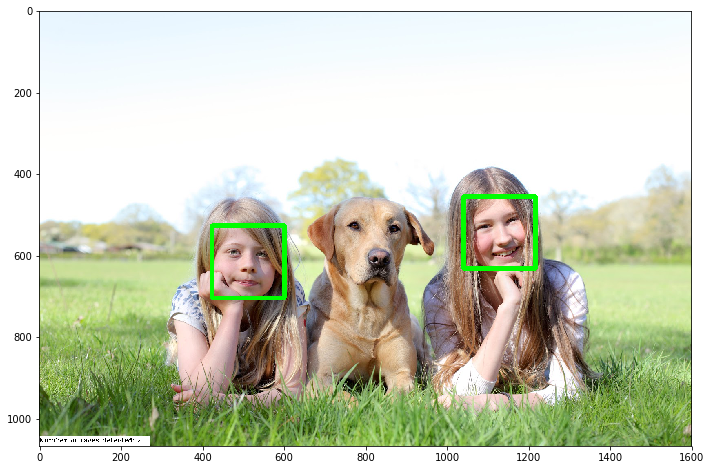

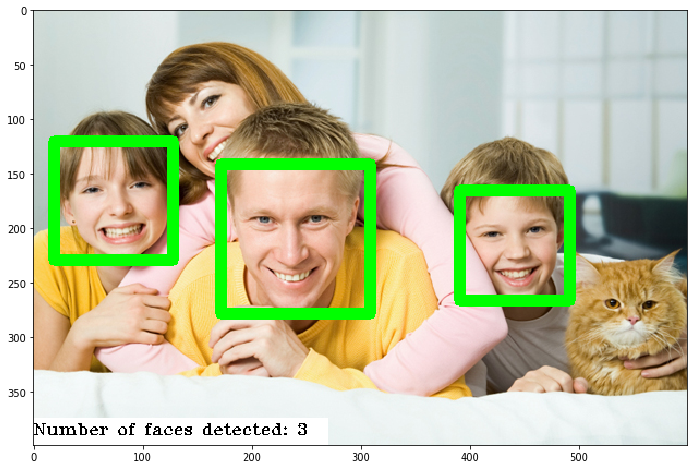

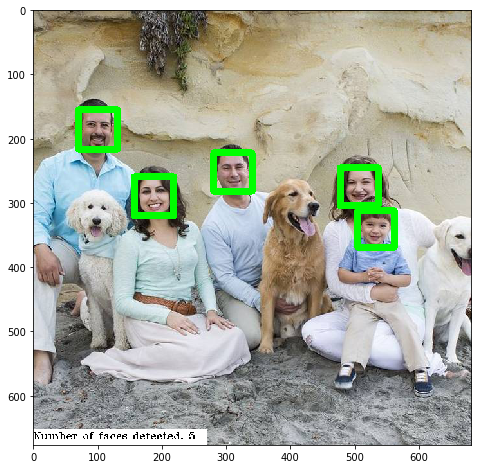

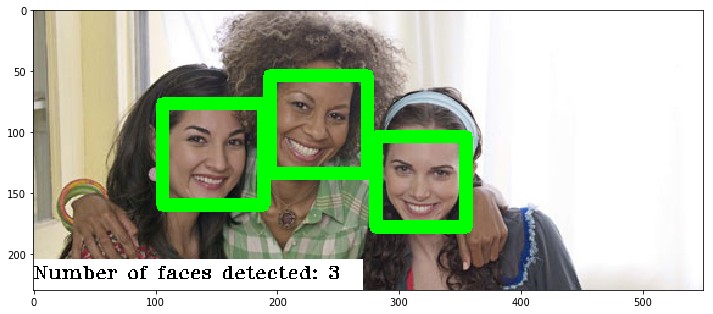

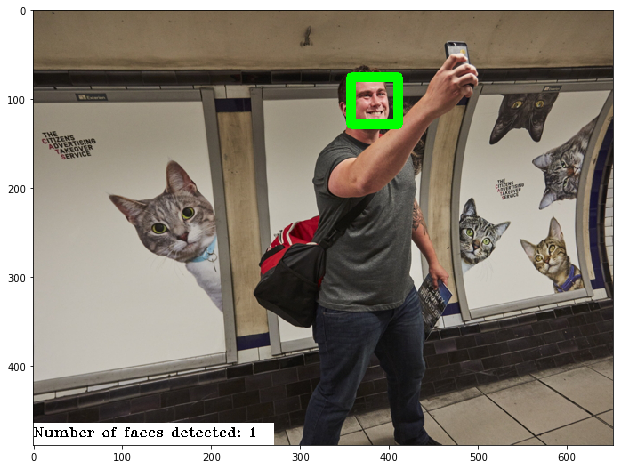

In [189]:
face_dectect_image('../data/test_image/cascade')

### Part 1.3 - Real Time Face Detection with WebCam
After we improved our model, we wanted to further develop our model. Therefore, in this part, we implemented real time face detection using WebCam. You can click on the button below to release the cam. Press "Q" to quit the cam.

In [16]:
# %load ../lib/counting_faces_webcam.py
#!/usr/bin/env python3
"""
Created on Sun Apr 22 16:14:00 2018

@author: zailchen
"""

def face_dectect_webcam(scaleFactor = 1.3, minNeighbors = 5):


    import numpy as np
    import cv2
    from math import sin, cos, radians
    
    
    def rotate_image(img, angle):
        if angle == 0: return img
        # print("checked for shape".format(image.shape))
        height, width = img.shape[:2]
        rot_mat = cv2.getRotationMatrix2D((width/2, height/2), angle, 0.9)
        result = cv2.warpAffine(img, rot_mat, (width, height), flags=cv2.INTER_LINEAR)
        return result
    
    def rotate_point(pos, img, angle):
        if angle == 0: return pos
        x = pos[:,0] - img.shape[1]*0.4
        y = pos[:,1] - img.shape[0]*0.4
        newx = x*cos(radians(angle)) + y*sin(radians(angle)) + img.shape[1]*0.4
        newy = -x*sin(radians(angle)) + y*cos(radians(angle)) + img.shape[0]*0.4
        return np.array((newx, newy, pos[:,2], pos[:,3]), int).T
    
    
    face_cascade = cv2.CascadeClassifier('../lib/haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)
    
    while 1:
        ret, img = cap.read()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        for angle in [0, -45, 45]:
            rimg = rotate_image(gray, angle)
            faces = face_cascade.detectMultiScale(rimg, scaleFactor, minNeighbors)
            
            if len(faces):
                    faces = rotate_point(faces, img, -angle)
                    break
        
       
        for (x,y,w,h) in faces:
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        
        cv2.rectangle(img, ((0,img.shape[0] -25)),(270, img.shape[0]), (255,255,255), -1)
        
        if type(faces) == tuple:
            cv2.putText(img, "Number of faces detected: 1" , (0,img.shape[0] -10), cv2.FONT_HERSHEY_TRIPLEX, 0.5,  (0,0,0), 1)
        else:
            cv2.putText(img, "Number of faces detected: " + str(faces.shape[0]), (0,img.shape[0] -10), cv2.FONT_HERSHEY_TRIPLEX, 0.5,  (0,0,0), 1)
    
    
        cv2.imshow('img',img)
        if cv2.waitKey(25) & 0xFF == ord('q'):
              cv2.destroyAllWindows()
              cap.release()
              break
        
  

In [184]:
'''




Press Q to close the camera 




'''

button = widgets.Button(description="Press Q to Quit the Cam! Click to Release.")
display(button)

def on_button_clicked(b):
    face_dectect_webcam()

button.on_click(on_button_clicked)






Button(description='Press Q to Quit the Cam! Click to Release.', style=ButtonStyle())

## Part 2 - Object Detection API using Tensorflow
After we constructed our model in Part 1, we realized there exist some limitations in cascade model. Cascade model tends to have lower accuracy in side faces or partially showed faces. Also, cascade cannot detect highly rotated faces. To overcome such limitations, a popular and powerful approach is the use of tensorflow. In this section, we implement object detection with a pretrained model, Tensorflow Object Detection API. This model requires intallation of tensorflow. Further instruction of the installation can be referred to https://github.com/tensorflow/models/tree/master/research/object_detection. This model can detect and categorize object, including person, bottle, cellphone, etc. However, cascada model would result better if only faces are showed on an image while this API model would result better if more parts of human body are showed.

### Part 2.1 - Object Detection API with Tensorflow on Image
Similar to Part 1.1, we started off with object detection using image. We can see now the model can not only detect human faces but the entire human figure. Moreover, this more advanced model allows us to detect objects other than human, for example, dogs, cats, bottles, cell phones, clocks and so on.

In [ ]:
os.chdir('../doc')
# %load ../lib/tensorflowFn.py

def objectDetection(directory = '../data/test_image/tensorflow'):  
    import cv2
    # coding: utf-8
    # # Object Detection Demo
    # Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.
    
    # # Imports
    
    
    import numpy as np
    import os
    import six.moves.urllib as urllib
    import sys
    import tarfile
    import tensorflow as tf
    import zipfile
    
    from collections import defaultdict
    from io import StringIO
    from matplotlib import pyplot as plt
    from PIL import Image
    
    # This is needed since the notebook is stored in the object_detection folder.
    #cwd = os.getcwd()
    os.chdir('../lib')
    #sys.path.append("..")
    import object_detection
    os.chdir('../lib/object_detection')
    from object_detection.utils import ops as utils_ops
    
    if tf.__version__ < '1.4.0':
      raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
    
    
    # ## Env setup
    
    
    # This is needed to display the images.
    get_ipython().magic('matplotlib inline')
    
    
    # ## Object detection imports
    # Here are the imports from the object detection module.
    
    
    from utils import label_map_util
    
    from utils import visualization_utils as vis_util
    
    
    # # Model preparation 
    
    # ## Variables
    # 
    # Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  
    # 
    # By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.
    
    
    # What model to download.
    MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
    MODEL_FILE = MODEL_NAME + '.tar.gz'
    DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
    
    # Path to frozen detection graph. This is the actual model that is used for the object detection.
    PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
    
    # List of the strings that is used to add correct label for each box.
    PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
    
    NUM_CLASSES = 90
    
    
    # ## Download Model
    
    if False:   
        opener = urllib.request.URLopener()
        opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
        tar_file = tarfile.open(MODEL_FILE)
        for file in tar_file.getmembers():
          file_name = os.path.basename(file.name)
          if 'frozen_inference_graph.pb' in file_name:
            tar_file.extract(file, os.getcwd())
        
    
    # ## Load a (frozen) Tensorflow model into memory.
    
    
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    
    
    # ## Loading label map
    # Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine
    
    
    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    
    
    # ## Helper code
    
    
    def load_image_into_numpy_array(image):
      (im_width, im_height) = image.size
      return np.array(image.getdata()).reshape(
          (im_height, im_width, 3)).astype(np.uint8)
    
    
    # # Detection
    
    # For the sake of simplicity we will use only 2 images:
    # image1.jpg
    # image2.jpg
    # If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
    PATH_TO_TEST_IMAGES_DIR = directory
    TEST_IMAGES_NAMES = os.listdir(directory)
    TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, TEST_IMAGES_NAMES[i]) for i in range(1,len(TEST_IMAGES_NAMES))]
    
    # Size, in inches, of the output images.
    IMAGE_SIZE = (12, 8)
    
    
    
    def run_inference_for_single_image(image, graph):
      with graph.as_default():
        with tf.Session() as sess:
          # Get handles to input and output tensors
          ops = tf.get_default_graph().get_operations()
          all_tensor_names = {output.name for op in ops for output in op.outputs}
          tensor_dict = {}
          for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
          ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
              tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                  tensor_name)
          if 'detection_masks' in tensor_dict:
            # The following processing is only for single image
            detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
            detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
            # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
            real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
            detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
            detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
            detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                detection_masks, detection_boxes, image.shape[0], image.shape[1])
            detection_masks_reframed = tf.cast(
                tf.greater(detection_masks_reframed, 0.5), tf.uint8)
            # Follow the convention by adding back the batch dimension
            tensor_dict['detection_masks'] = tf.expand_dims(
                detection_masks_reframed, 0)
          image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
    
          # Run inference
          output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})
    
          # all outputs are float32 numpy arrays, so convert types as appropriate
          output_dict['num_detections'] = int(output_dict['num_detections'][0])
          output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
          output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
          output_dict['detection_scores'] = output_dict['detection_scores'][0]
          if 'detection_masks' in output_dict:
            output_dict['detection_masks'] = output_dict['detection_masks'][0]
      return output_dict
    
    
    
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      output_dict = run_inference_for_single_image(image_np, detection_graph)
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks'),
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)
      
    os.chdir('../../doc')
    


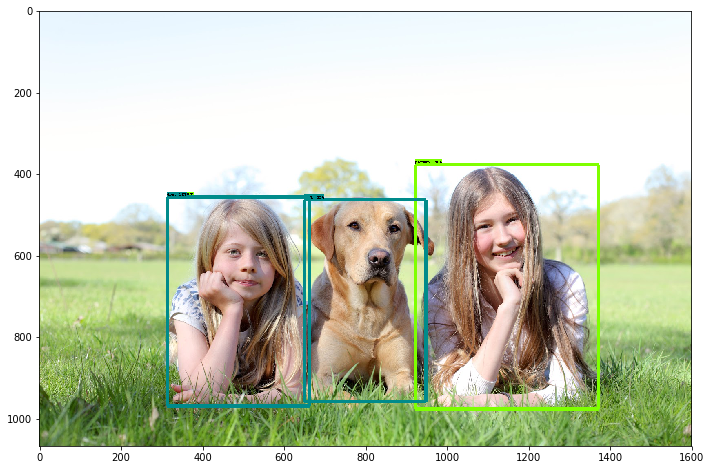

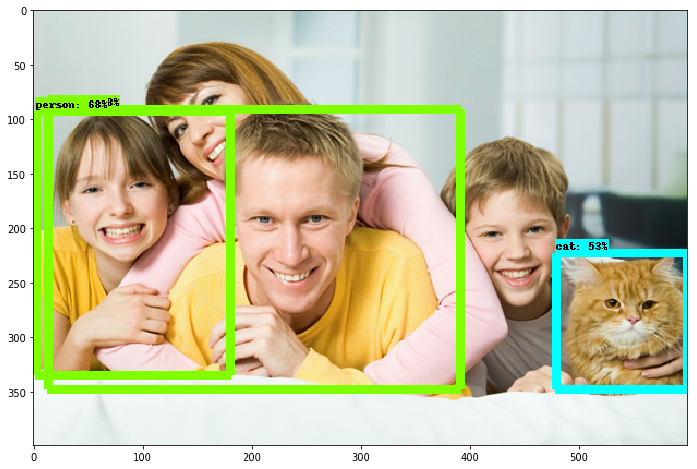

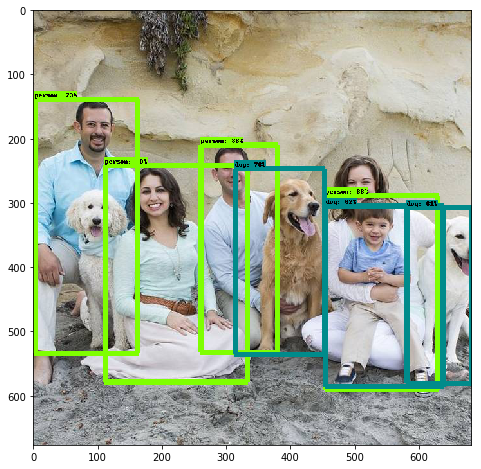

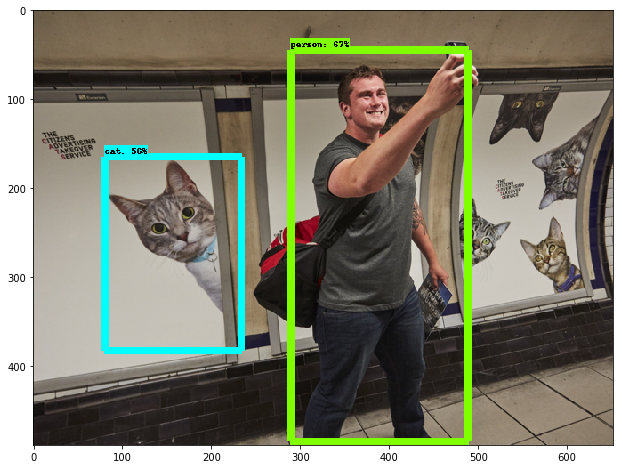

In [160]:
#os.chdir('../../doc')
#os.getcwd()
objectDetection('../../data/test_image/tensorflow')

### Part 2.2 - Real Time Object Detection API with Tensorflow using WebCam
Part 2.1 resulted in highly accurate result detecting most of the objects into their corresponding categories. We further improved the model by implementing the model using WebCam as an input. The result was again very accurate. You can click on the button below to release the cam. Press "Q" to quit the cam.

In [162]:
os.chdir('../doc')
# %load ../lib/tensorflowFnVideo.py


def objectDetectionCap():  
    import cv2
    import numpy as np 
    import os
    import six.moves.urllib as urllib
    import sys
    import tarfile
    import tensorflow as tf
    import zipfile
    
    from collections import defaultdict
    from io import StringIO
    from matplotlib import pyplot as plt
    from PIL import Image
    

    # This is needed since the notebook is stored in the object_detection folder.
    #cwd = os.getcwd()
    os.chdir('../lib')
    #sys.path.append("..")
    import object_detection
    os.chdir('../lib/object_detection')
    from object_detection.utils import ops as utils_ops
    
    if tf.__version__ < '1.4.0':
      raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
    
    
    # ## Env setup
    
    
    # This is needed to display the images.
    get_ipython().magic('matplotlib inline')
    
    
    # ## Object detection imports
    # Here are the imports from the object detection module.
    
    
    from utils import label_map_util
    
    from utils import visualization_utils as vis_util
    
    
    # # Model preparation 
    
    # ## Variables
    # 
    # Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  
    # 
    # By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.
    
    
    # What model to download.
    MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
    MODEL_FILE = MODEL_NAME + '.tar.gz'
    DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
    
    # Path to frozen detection graph. This is the actual model that is used for the object detection.
    PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
    
    # List of the strings that is used to add correct label for each box.
    PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
    
    NUM_CLASSES = 90
    
   
    # ## Download Model
    
#    opener = urllib.request.URLopener()
#    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
#    tar_file = tarfile.open(MODEL_FILE)
#    for file in tar_file.getmembers():
#      file_name = os.path.basename(file.name)
#      if 'frozen_inference_graph.pb' in file_name:
#        tar_file.extract(file, os.getcwd())
   
    
    # ## Load a (frozen) Tensorflow model into memory.
    
    
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    
    
    # ## Loading label map
    # Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine
    
    
    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)

    
    cap = cv2.VideoCapture(0)
    with detection_graph.as_default():
      with tf.Session(graph=detection_graph) as sess:
       ret = True
       while (ret):
          ret,image_np = cap.read()
          image_np_expanded = np.expand_dims(image_np, axis=0)
          image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
          boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
          scores = detection_graph.get_tensor_by_name('detection_scores:0')
          classes = detection_graph.get_tensor_by_name('detection_classes:0')
          num_detections = detection_graph.get_tensor_by_name('num_detections:0')
          (boxes, scores, classes, num_detections) = sess.run(
                  [boxes, scores, classes, num_detections],
                  feed_dict={image_tensor: image_np_expanded})
          vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=8)
          cv2.imshow('image', cv2.resize(image_np,(1280,800)))
          if cv2.waitKey(25) & 0xFF == ord('q'):
              cv2.destroyAllWindows()
              cap.release()
              break
    os.chdir('../../doc')




In [185]:
'''




Press Q to close the camera 




'''

button = widgets.Button(description="Press Q to Quit the Cam! Click to Release.")
display(button)

def on_button_clicked(b):
    objectDetectionCap()

button.on_click(on_button_clicked)




Button(description='Press Q to Quit the Cam! Click to Release.', style=ButtonStyle())